# Plots para la tesis

Imports


In [60]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.formula.api import ols
from pathlib import Path

Paths a los archivos de resultados

In [61]:
data = {}
current_path = Path.cwd()
audio_folder = current_path.parent / 'audio-files'
plots_folder = current_path.parent / 'plots'
systems = [folder.name for folder in (audio_folder).iterdir() if folder.is_dir()]
results_columns = ['speaker_id', 'file_name', 'attack', 'snr', 'pesq', 'ber', 'time']

for system in systems:
    results = audio_folder / f'{system}' / 'results' / 'results.txt'
    data[f'{system}'] = pd.read_csv(results, sep='\s+', header=None, names=results_columns)

Estilos de los gráficos

In [62]:
plt.style.use('bmh')
sns.set_theme(style="whitegrid", context="talk")

Gráfico de la evaluación perceptual de la calidad del habla (snr)

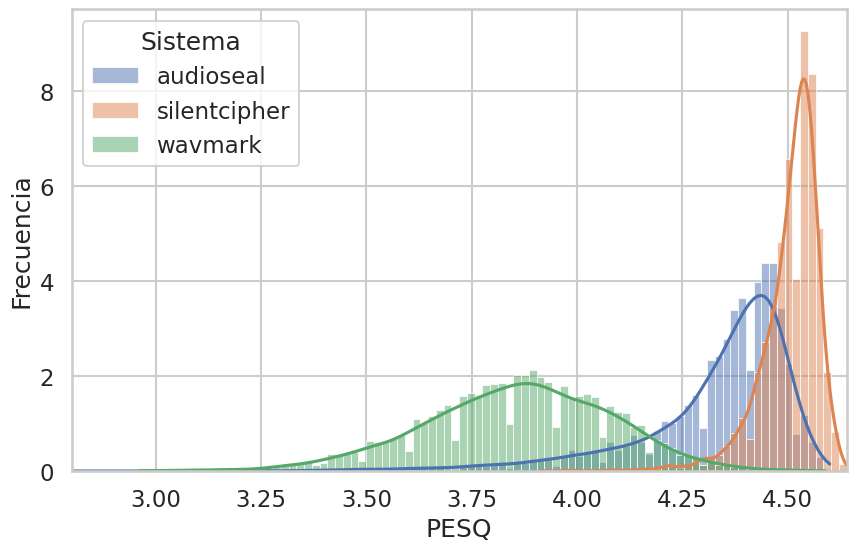

In [72]:
plt.figure(figsize=(10, 6))
plt.xlabel('PESQ')
plt.ylabel('Frecuencia')

pesq_min = min(data[system]['pesq'].min() for system in systems)
pesq_max = max(data[system]['pesq'].max() for system in systems)

bins = np.linspace(pesq_min, pesq_max, 101)  # 50 bins, 51 edges

for system, df in data.items():
    sns.histplot(data=df, x='pesq', bins=bins, kde=True, stat='density', label=system, alpha=0.5)
plt.legend(title='Sistema')
plt.xlim([pesq_min, pesq_max])
plt.savefig(plots_folder / 'pesq_combined.svg')
plt.show()

Grafico de la relación señal a ruido

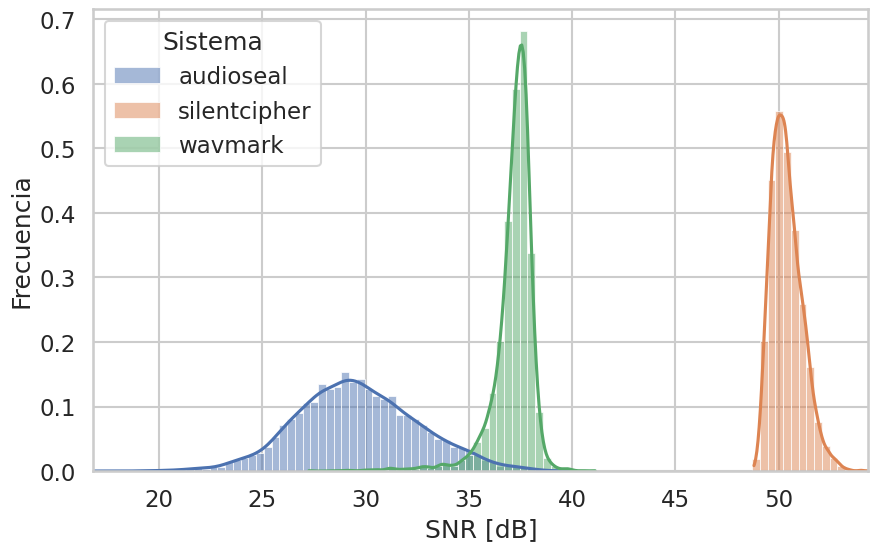

In [71]:
plt.figure(figsize=(10, 6))
plt.xlabel('SNR [dB]')
plt.ylabel('Frecuencia')

snr_min = min(data[system]['snr'].min() for system in systems)
snr_max = max(data[system]['snr'].max() for system in systems)

bins = np.linspace(snr_min, snr_max, 101)

for system, df in data.items():
    sns.histplot(data=df, x='snr', bins=bins, kde=True, stat='density', label=system, alpha=0.5)

plt.legend(title='Sistema')
plt.xlim([snr_min, snr_max])
plt.savefig(plots_folder / 'snr_combined.svg')
plt.show()

Scatter plot de la relación entre SNR y PESQ para cada ataque

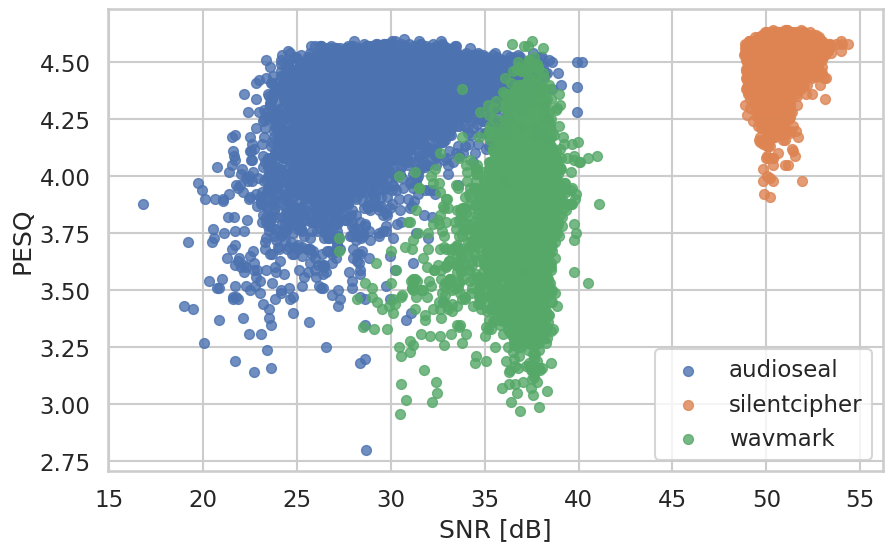

In [65]:
plt.figure(figsize=(10, 6))
plt.xlabel('SNR [dB]')
plt.ylabel('PESQ')
for system in systems:
    sns.regplot(x='snr', y='pesq', data=data[system], label=system, marker='o', scatter_kws={'s': 50}, fit_reg=False)
plt.xlabel('SNR [dB]')
plt.ylabel('PESQ')
plt.legend()
plt.savefig(plots_folder / 'snr-pesq.svg')
plt.show()


In [66]:
correlation, p_value = pearsonr(data['audioseal']['snr'], data['audioseal']['pesq'])
print(f'Coeficiente de correlación de Pearson: {correlation}')
print(f'Valor p: {p_value}')

model = ols('pesq ~ C(attack) + snr', data=data['audioseal']).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

Coeficiente de correlación de Pearson: 0.426389958018228
Valor p: 0.0
               sum_sq      df            F         PR(>F)
C(attack)   38.303875     5.0   305.271344  5.396491e-302
snr         43.504863     1.0  1733.608895   0.000000e+00
Residual   218.200761  8695.0          NaN            NaN


Plot del tiempo de inferencia de cada sistema

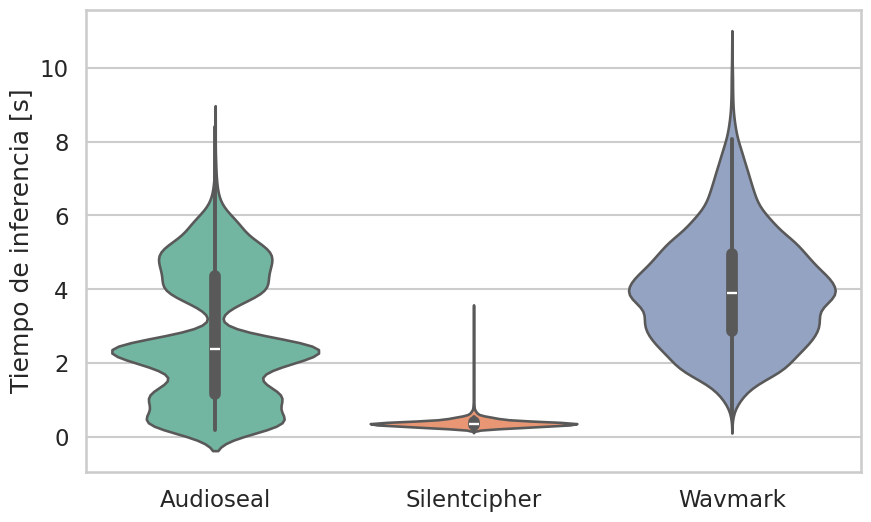

In [67]:
placeholder_data = pd.DataFrame({
    'time': pd.concat([data['audioseal']['time'], data['silentcipher']['time'], data['wavmark']['time']]),
    'group': ['Audioseal'] * len(data['audioseal']) + ['Silentcipher'] * len(data['silentcipher']) + ['Wavmark'] * len(data['wavmark'])
})
plt.figure(figsize=(10, 6))
sns.violinplot(x='group', y='time', hue='group', legend=False, data=placeholder_data, palette='Set2')
plt.ylabel('Tiempo de inferencia [s]')
plt.xlabel('')
plt.savefig(plots_folder / "inference_time.svg")
plt.show()

Ahora voy a plotear el bit error rate para cada sistema

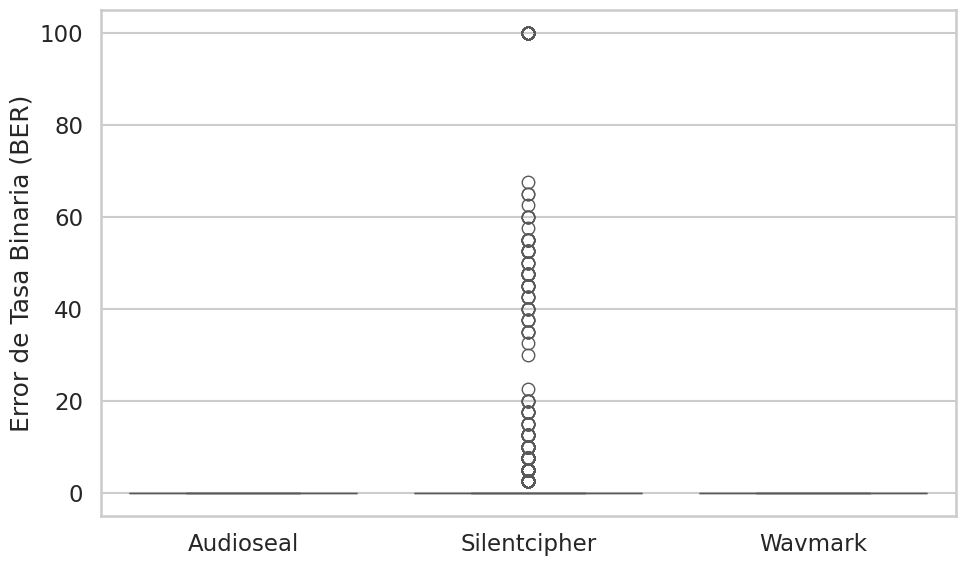

In [68]:
# Suponiendo que tienes un DataFrame que contiene los BER por sistema
ber_df = pd.DataFrame({
    'System': ['Audioseal'] * len(data['audioseal']['ber']) + 
              ['Silentcipher'] * len(data['silentcipher']['ber']) +
              ['Wavmark'] * len(data['wavmark']['ber']),
    'BER': list(data['audioseal']['ber']) + list(data['silentcipher']['ber']) + list(data['wavmark']['ber'])
})
plt.figure(figsize=(10, 6))
sns.boxplot(x='System', y='BER', data=ber_df, hue='System', legend=False, palette='Set2')
plt.ylabel('Error de Tasa Binaria (BER)')
plt.xlabel('')
plt.tight_layout()
plt.savefig(plots_folder / "ber.svg")
plt.show()

Ahora quiero plotear el tiempo de inferencia normalizado con respecto a la duración de cada archivo

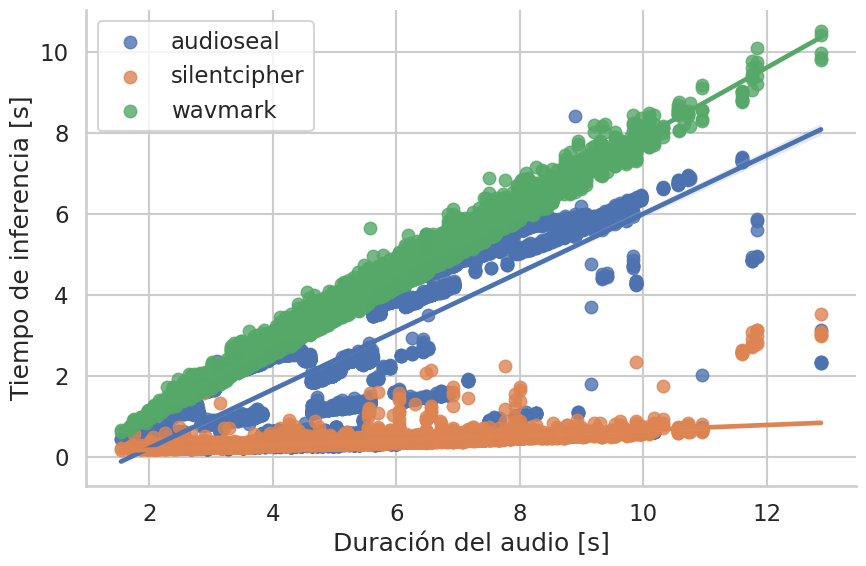

In [70]:
protocol_columns = ['speaker_id', 'file_name', 'attack', 'key', 'duration']
protocol_df = pd.read_csv('/home/jalma/Music/datasets/HABLA-spoofed/protocol-spoofed.txt', sep='\s+', header=None, names=protocol_columns)

merged_data = []

for system in systems:
    results_df = data[system]
    merged_df = pd.merge(results_df, protocol_df[['file_name', 'duration']], on='file_name')
    merged_df['system'] = system
    merged_data.append(merged_df)
    
final_df = pd.concat(merged_data, ignore_index=True)
sns.lmplot(x='duration', y='time', hue='system', data=final_df, markers='o', height=6, aspect=1.5, legend=False)

plt.xlabel('Duración del audio [s]')
plt.ylabel('Tiempo de inferencia [s]')
plt.legend()
plt.savefig(plots_folder / "time-dur.svg")
plt.show()